# Preprocessing

In [37]:
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
import os

In [38]:
!ls

A1_SVD_test_pred_with_converge.csv
A1_SVD_test_result_with_bias_with_converge.csv
A1_SVD_train_result_with_bias_with_converge.csv
A1_SVD_with_bias.py
A2_SVD_test_result_pred_with_step_50_converge.csv
A2_SVD_test_result_with_feedback_with_step_50_converge.csv
A2_SVD_train_result_with_feedback_with_step_50_converge.csv
A2_SVD_with_implicit_feedback.py
A3_SVD_v1.py
A3_SVD_v1_test_result_converge.csv
A3_SVD_v1_test_result_pred_converge.csv
A3_SVD_v1_train_converge.csv
A4_SVD_v2.py
A4_SVD_v2_test_result_converge.csv
A4_SVD_v2_test_result_pred_converge.csv
A4_SVD_v2_train_converge.csv
B1_item_based_CF.py
B1_item_based_CF_item_similarity_with_weight.csv
B1_item_based_CF_test_pred_1.csv
B1_item_based_CF_test_result_1.csv
B1_item_based_CF_train_result_1.csv
B2_SVD.py
B2_SVD_test_pred_converge.csv
B2_SVD_test_result_converge.csv
B2_SVD_train_result_converge.csv
B3.py
B3_test_pred_Random_Forest.csv
B3_test_result_Random_Forest.csv
Netflix_dataset
create_time_to_user_movie_rating.py
model_performa

In [39]:
#Preprocessing
##Converting / Merging whole data to required format: u_i, m_j, r_ij
start = datetime.now()
if not os.path.isfile('Netflix_dataset/data.csv'):
    # Creating a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('Netflix_dataset/data.csv', mode='w')

    row = list()
    files = ['Netflix_dataset/combined_data_1.txt', 'Netflix_dataset/combined_data_2.txt',
             'Netflix_dataset/combined_data_3.txt', 'Netflix_dataset/combined_data_4.txt']

    for file in files:
        print(1)
        print("Reading ratings from {}...".format(file))

        with open(file) as f:
            for line in f:
                del row[:]  # We might not have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")

    data.close()

print('Time taken :', datetime.now() - start)

print("creating the dataframe from data.csv file..")
df = pd.read_csv('Netflix_dataset/data.csv', sep=',',names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

print(df.head())

print(df.describe()['rating'])

Time taken : 0:00:00.000817
creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..
         movie     user  rating       date
254722      55  1972971       1 1999-12-09
1859690    344   204439       3 1999-12-09
2269785    432   510180       3 1999-12-12
1363611    295   731941       1 1999-12-17
1166671    269   122223       4 1999-12-18
count    2.556150e+06
mean     3.620267e+00
std      1.081373e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [40]:
#checking NaN values
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

#Removing Duplicates
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

No of Nan values in our dataframe :  0
There are 0 duplicate rating entries in the data..


In [41]:
#Spliting data into Train and Test(80:20)
if not os.path.isfile('Netflix_dataset/train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("Netflix_dataset/train.csv", index=False)

if not os.path.isfile('Netflix_dataset/test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("Netflix_dataset/test.csv", index=False)

train_df = pd.read_csv("Netflix_dataset/train.csv", parse_dates=['date'])
test_df = pd.read_csv("Netflix_dataset/test.csv")

In [42]:
import pandas as pd
from collections import defaultdict
import os
import csv
import sys
import math
import numpy as np

In [43]:
def create_movie_user_dict(df):
    if not os.path.isfile('movie_user.csv'):
        movie_user = defaultdict(list)
        for iter, row in df.iterrows():
            #movie_user: key-movie; value-[user,rating]
            movie_user[row[0]].append([row[1], row[2]])
        with open('movie_user.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            header = ['movie', 'user_and_rating']
            w.writerow(header)
            w.writerows(movie_user.items())
    else:
        movie_user = pd.read_csv('movie_user.csv').set_index('movie').to_dict('index')
        for movie in movie_user.keys():
            m_u = movie_user[movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user[movie]['movie_and_rating'] = m_u
    if not os.path.isfile('user_movie.csv'):
        user_movie = defaultdict(list)
        for iter, row in df.iterrows():
            #movie_user: key-movie; value-[user,rating]
            user_movie[row[1]].append([row[0], row[2]])
        with open('user_movie.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            header = ['user', 'movie_and_rating']
            w.writerow(header)
            w.writerows(user_movie.items())
    else:
        user_movie = pd.read_csv('user_movie.csv').set_index('user').to_dict('index')
        for user in user_movie.keys():
            u_m = user_movie[user]['movie_and_rating'].strip('[').strip(']').split('], ')
            u_m = [a.replace('[', '').split(',') for a in u_m]
            user_movie[user]['movie_and_rating'] = u_m
    return movie_user, user_movie

def create_movie_user_dict_test(df):
    if not os.path.isfile('movie_user_test.csv'):
        movie_user = defaultdict(list)
        for iter, row in df.iterrows():
            #movie_user: key-movie; value-[user,rating]
            movie_user[row[0]].append([row[1], row[2]])
        with open('movie_user_test.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            header = ['movie', 'user_and_rating']
            w.writerow(header)
            w.writerows(movie_user.items())
    else:
        movie_user = pd.read_csv('movie_user_test.csv').set_index('movie').to_dict('index')
        for movie in movie_user.keys():
            m_u = movie_user[movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user[movie]['movie_and_rating'] = m_u
    if not os.path.isfile('user_movie_test.csv'):
        user_movie = defaultdict(list)
        for iter, row in df.iterrows():
            #movie_user: key-movie; value-[user,rating]
            user_movie[row[1]].append([row[0], row[2]])
        with open('user_movie_test.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            header = ['user', 'movie_and_rating']
            w.writerow(header)
            w.writerows(user_movie.items())
    else:
        user_movie = pd.read_csv('user_movie_test.csv').set_index('user').to_dict('index')
        for user in user_movie.keys():
            u_m = user_movie[user]['movie_and_rating'].strip('[').strip(']').split('], ')
            u_m = [a.replace('[', '').split(',') for a in u_m]
            user_movie[user]['movie_and_rating'] = u_m
    return movie_user, user_movie

In [44]:
class model_comparing:
    def __init__(self):
        self.rmse = {}
        self.mae = {}
        self.mape = {}
model_comparing_train = model_comparing()
model_comparing_test = model_comparing()

## B1-item-similarity-cf

In [45]:
def create_item_similarity_dictionary(movie_user, flag):
    if flag == 1:
        if not os.path.isfile('B1_item_based_CF_item_similarity.csv'):
            item_similarity = defaultdict(list)
            count = 0
            for movie_1 in movie_user:
                if count % 100 == 0:
                    print(count)
                count += 1
                for movie_2 in movie_user:
                    if movie_1 == movie_2 or movie_2 in item_similarity or movie_1 in item_similarity: continue
                    #find who rate movie1 adn movie2
                    user_rate_movie_1 = set([item[0] for item in movie_user[movie_1]])
                    user_rate_movie_2 = set([item[0] for item in movie_user[movie_2]])
                    users_rate_both_movie = user_rate_movie_2 & user_rate_movie_2
                    users_rate_at_least_one_movie = user_rate_movie_1 | user_rate_movie_2
                    item_similarity[movie_1] = [movie_2, len(users_rate_both_movie) / len(users_rate_at_least_one_movie)]
                    item_similarity[movie_2] = [movie_1, len(users_rate_both_movie) / len(users_rate_at_least_one_movie)]
            with open('B1_item_based_CF_item_similarity.csv', 'w', encoding='utf-8-sig') as f:
                w = csv.writer(f)
                header = ['movie', 'other_movie and similarity score']
                w.writerow(header)
                w.writerows(item_similarity.items())
        else:
            item_similarity = pd.read_csv('B1_item_based_CF_item_similarity.csv').set_index('movie').to_dict()
            print(item_similarity)
    elif flag == 2:
        if not os.path.isfile('B1_item_based_CF_item_similarity_with_weight.csv'):
            item_similarity = defaultdict(list)
            summ = defaultdict(int)
            for movie_1 in movie_user:
                for movie_2 in movie_user:
                    if movie_1 == movie_2: continue
                    #find who rate movie1 adn movie2
                    user_and_rating_1 = movie_user[movie_1]['user_and_rating'].strip('[').strip(']').split('], ')
                    user_and_rating_1 = [a.replace('[', '').split(',') for a in user_and_rating_1]
                    users_rate_movie_1 = {u_s[0]: u_s[1] for u_s in user_and_rating_1}
                    user_and_rating_2 = movie_user[movie_2]['user_and_rating'].strip('[').strip(']').split('], ')
                    user_and_rating_2 = [a.replace('[', '').split(',') for a in user_and_rating_2]
                    users_rate_movie_2 = {u_s[0]: u_s[1] for u_s in user_and_rating_2}
                    users_rate_both_movie = set([user for user in users_rate_movie_1.keys()]) & set([user for user in users_rate_movie_2.keys()])
                    users_rate_both_movie_score = 0
                    users_rate_movie1_score, users_rate_movie2_score = 0, 0
                    for item in users_rate_both_movie:
                        users_rate_both_movie_score += int(users_rate_movie_1[item]) * int(users_rate_movie_2[item])
                    for item in users_rate_movie_1.keys():
                        users_rate_movie1_score += int(users_rate_movie_1[item])**2
                    for item in users_rate_movie_2.keys():
                        users_rate_movie2_score += int(users_rate_movie_2[item])**2
                    users_rate_movie1_score = math.sqrt(users_rate_movie1_score)
                    users_rate_movie2_score = math.sqrt(users_rate_movie2_score)
                    item_similarity[movie_1].append([movie_2, users_rate_both_movie_score/(users_rate_movie1_score * users_rate_movie2_score)])
                    item_similarity[movie_2].append([movie_1, users_rate_both_movie_score/(users_rate_movie1_score * users_rate_movie2_score)])
                    summ[movie_1] += users_rate_both_movie_score/(users_rate_movie1_score * users_rate_movie2_score)
                    summ[movie_2] += users_rate_both_movie_score/(users_rate_movie1_score * users_rate_movie2_score)
            for movie1 in item_similarity:
                for movie2_similarity in item_similarity[movie1]:
                    movie2_similarity[1] /= summ[movie_1]

            with open('B1_item_based_CF_item_similarity_with_weight.csv', 'w', encoding='utf-8-sig') as f:
                w = csv.writer(f)
                header = ['movie', 'other_movie and similarity score']
                w.writerow(header)
                w.writerows(item_similarity.items())
        else:
            item_similarity = pd.read_csv('B1_item_based_CF_item_similarity_with_weight.csv').set_index('movie').to_dict('index')
            for item in item_similarity.keys():
                item_to_item = item_similarity[item]['other_movie and similarity score'].strip('[').strip(']').split('], ')
                item_to_item = [a.replace('[', '').split(',') for a in item_to_item]
                item_similarity[item]['other_movie and similarity score'] = item_to_item
    return item_similarity

In [46]:
#2. calculate the probability for each item to be chosen by target user
#to predict target_user_i's rating to target_Movie,
# add all target_user's history movie's rating * similarity
def predict_target_movie_score_from_target_user(item_similarity, user_movie, target_user, target_movie, avg):
    predict_score = 0
    if int(target_user) not in user_movie:
        return avg
    for history_movie, rating in user_movie[int(target_user)]['movie_and_rating']:
        for movie,score in item_similarity[int(history_movie)]['other_movie and similarity score']:
            if int(movie) == int(target_movie):
                predict_score += float(score) * float(rating)
                break
    #print(target_user, target_movie, predict_score)
    if predict_score < 1: predict_score = 1
    elif predict_score > 5: predict_score = 5
    return predict_score

In [47]:
def train(movie_user, user_movie, avg, item_similarity):
    if not os.path.isfile('B1_item_based_CF_train_result_1.csv'):
        print('train!!')
        rmse_sum = 0.0
        mae = 0.0
        count = 0
        mape = 0.0
        step = 1
        for target_movie in movie_user.keys():
            m_u = movie_user[target_movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u= [a.replace('[', '').split(',') for a in m_u]
            movie_user[target_movie]['user_and_rating'] = m_u
            for user_rating in movie_user[target_movie]['user_and_rating']:
                target_user, target_rating = user_rating[0], user_rating[1]
                eui = float(target_rating) - predict_target_movie_score_from_target_user(item_similarity, user_movie, target_user, target_movie, avg)
                rmse_sum += eui ** 2
                mae += abs(eui)
                mape += abs(eui) / float(target_rating)
                count += 1
        rmse = np.sqrt(rmse_sum/count)
        mae = np.sqrt(mae/count)
        mape = mape/count * 100
        print(f'the rmse for training data is {rmse},'
              f'the mae for training data is {mae},'
              f'the mape for training data is {mape}')
        result = {'rmse': rmse,
                  'mae': mae,
                  'mape':mape}
        pd.DataFrame(result).to_csv('B1_item_based_CF_train_result_1.csv')
        #with open('B1_item_based_CF_train_result_1.csv','w',encoding ='utf-8-sig') as f:
        #    w = csv.writer(f)
        #    w.writerows(result.items())
    else: 
        print("GREAT!You don't need to train again!")
        result = pd.read_csv('B1_item_based_CF_train_result_1.csv', header = None).to_dict(orient='index')
        rmse = result[0][1]
        mae = result[1][1]
        mape = result[2][1]
        print(f'the rmse for training data is {rmse},'
              f'the mae for training data is {mae},'
              f'the mape for training data is {mape}')
        
        model_comparing_train.rmse['B1'] = rmse
        model_comparing_train.mae['B1'] = mae
        model_comparing_train.mape['B1'] = mape

In [48]:
def test(movie_user, user_movie, avg, item_similarity):
    if not os.path.isfile('B1_item_based_CF_test_result_1.csv'):
        rmse_sum = 0.0
        mae = 0.0
        count = 0
        step = 1
        mape = 0.0
        pred_dict = {}
        for target_movie in movie_user.keys():
            m_u = movie_user[int(target_movie)]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u= [a.replace('[', '').split(',') for a in m_u]
            movie_user[target_movie]['user_and_rating'] = m_u
            for user_rating in movie_user[target_movie]['user_and_rating']:
                target_user, target_rating = user_rating[0], user_rating[1]
                pred_rating = predict_target_movie_score_from_target_user(item_similarity, user_movie, target_user, target_movie, avg)
                eui = float(target_rating) - pred_rating
                pred_dict[(target_movie, target_user)] = [pred_rating, float(target_rating)]
                rmse_sum += eui ** 2
                mae += abs(eui)
                mape += abs(eui)/float(target_rating)
                count += 1
        rmse = np.sqrt(rmse_sum/count)
        mae = np.sqrt(mae/count)
        mape = mape/count * 100
        print(f'the rmse for test data is {rmse},'
              f'the mae for test data is {mae}'
              f'the mape for test data is {mape}')
        result = {'rmse': rmse, 'mae':mae, 'mape':mape}
        pd.DataFrame(result).to_csv('B1_item_based_CF_test_result.csv')
        pd.DataFrame(pred_dict).to_csv('B1_item_based_CF_test_pred.csv')
    else:
        result = pd.read_csv('B1_item_based_CF_test_result_1.csv', header = None).to_dict(orient='index')
        rmse = result[0][1]
        mae = result[1][1]
        mape = result[2][1]
        print(f'the rmse for test data is {rmse},'
              f'the mae for test data is {mae},'
              f'the mape for test data is {mape}')
        model_comparing_test.rmse['B1'] = rmse
        model_comparing_test.mae['B1'] = mae
        model_comparing_test.mape['B1'] = mape

In [49]:
def recommendation():
    #flag = int(sys.argv[1])
    train_df = pd.read_csv("Netflix_dataset/train.csv", parse_dates=['date'])
    print(train_df.head())
    avg = np.mean(train_df['rating'])
    test_df = pd.read_csv("Netflix_dataset/test.csv", parse_dates=['date'])
    movie_user, user_movie = create_movie_user_dict(train_df)
    movie_user_test, user_movie_test = create_movie_user_dict_test(test_df)
    item_similarity = create_item_similarity_dictionary(movie_user, 2)
    train(movie_user, user_movie, avg, item_similarity)
    test(movie_user_test, user_movie_test, avg, item_similarity)
recommendation()

   movie     user  rating       date
0     55  1972971       1 1999-12-09
1    344   204439       3 1999-12-09
2    432   510180       3 1999-12-12
3    295   731941       1 1999-12-17
4    269   122223       4 1999-12-18
GREAT!You don't need to train again!
the rmse for training data is 2.818094564108298,the mae for training data is 1.6135410391247762,the mape for training data is 67.69809565232424
the rmse for test data is 2.207276151547295,the mae for test data is 1.358752971916809,the mape for test data is 52.87992053712729


## B2-SVD

In [50]:
def predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie):
    #print(target_user, target_movie)
    pu.setdefault(int(target_user), np.zeros((k,1)))
    qi.setdefault(int(target_movie), np.zeros((k,1)))
    first_term = np.array(pu[int(target_user)], dtype=np.float64)
    second_term = np.array(qi[int(target_movie)], dtype=np.float64)
    #print(first_term, second_term)
    rating = np.sum(first_term * second_term)
    if rating > 5: return 5
    if rating < 1: return 1
   # print(rating)
    return rating

In [51]:
!ls

A1_SVD_test_pred_with_converge.csv
A1_SVD_test_result_with_bias_with_converge.csv
A1_SVD_train_result_with_bias_with_converge.csv
A1_SVD_with_bias.py
A2_SVD_test_result_pred_with_step_50_converge.csv
A2_SVD_test_result_with_feedback_with_step_50_converge.csv
A2_SVD_train_result_with_feedback_with_step_50_converge.csv
A2_SVD_with_implicit_feedback.py
A3_SVD_v1.py
A3_SVD_v1_test_result_converge.csv
A3_SVD_v1_test_result_pred_converge.csv
A3_SVD_v1_train_converge.csv
A4_SVD_v2.py
A4_SVD_v2_test_result_converge.csv
A4_SVD_v2_test_result_pred_converge.csv
A4_SVD_v2_train_converge.csv
B1_item_based_CF.py
B1_item_based_CF_item_similarity_with_weight.csv
B1_item_based_CF_test_pred_1.csv
B1_item_based_CF_test_result_1.csv
B1_item_based_CF_train_result_1.csv
B2_SVD.py
B2_SVD_test_pred_converge.csv
B2_SVD_test_result_converge.csv
B2_SVD_train_result_converge.csv
B3.py
B3_test_pred_Random_Forest.csv
B3_test_result_Random_Forest.csv
Netflix_dataset
create_time_to_user_movie_rating.py
model_performa

In [52]:
def train(movie_user, user_movie,steps, gamma, Lambda, k, pu, qi):
    if not os.path.isfile('B2_SVD_train_result_converge.csv'):
        result = {}
        for target_movie in movie_user.keys():
            m_u = movie_user[target_movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user[target_movie]['user_and_rating'] = m_u
            qi.setdefault(int(target_movie), np.random.random((k, 1)) / 10 * np.sqrt(k))
        for target_user in user_movie.keys():
            pu.setdefault(int(target_user), np.random.random((k,1)) / 10 * np.sqrt(k))
        for step in range(steps):
            print(step)
            rmse_sum = 0.0
            mae = 0.0
            count = 0
            mape = 0.0
            for target_movie in movie_user.keys():
                for user_rating in movie_user[target_movie]['user_and_rating']:
                    target_user, target_rating = user_rating[0], user_rating[1]
                    eui = float(target_rating) - predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie)
                    rmse_sum += eui ** 2
                    mae += abs(eui)
                    mape += abs(eui) / float(target_rating)
                    #print(target_user, target_movie, eui)
                    count += 1
                    qi[int(target_movie)] += gamma * (eui * pu[int(target_user)] - Lambda * qi[int(target_movie)])
                    pu[int(target_user)] += gamma * (eui * qi[int(target_movie)] - Lambda * pu[int(target_user)])

            gamma = gamma * 0.95
            rmse = np.sqrt(rmse_sum/count)
            mae = np.sqrt(mae/count)
            mape = mape / count * 100
            print(f"the rmse for this step on training data is {rmse},"
                  f"the mae for this step on training data is {mae},"
                  f"the mape for this step on training data is {mape}")
            result[step] = [rmse, mae, mape]
            if step != 0 and abs(rmse - result[step - 1][0]) < 0.001:
                print('converge!!!')
                break
        with open('B2_SVD_train_result_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            header = ['step', 'rmse, mae and mape']
            w.writerow(header)
            w.writerows(result.items())
        return pu,qi
    else:
        print("GREAT!You don't need to train again!")
        result = pd.read_csv('B2_SVD_train_result_converge.csv', header = None).to_dict(orient='index')
        r = eval(result[len(result)-1][1])
        rmse = r[0]
        mae = r[1]
        mape = r[2]
        print(f'the rmse for training data is {rmse},'
              f'the mae for training data is {mae},'
              f'the mape for training data is {mape}')
        
        model_comparing_train.rmse['B2'] = rmse
        model_comparing_train.mae['B2'] = mae
        model_comparing_train.mape['B2'] = mape


In [53]:
def test(movie_user_test,user_movie_test, k, pu, qi):
    if not os.path.isfile('B2_SVD_test_result_converge.csv'):
        result = {}
        for target_movie in movie_user_test.keys():
            m_u = movie_user_test[target_movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user_test[target_movie]['user_and_rating'] = m_u
            qi.setdefault(int(target_movie), np.random.random((k, 1)) / 10 * np.sqrt(k))
        for target_user in user_movie_test.keys():
            pu.setdefault(int(target_user), np.random.random((k,1)) / 10 * np.sqrt(k))
        rmse_sum = 0.0
        mae = 0.0
        count = 0
        mape = 0.0
        pred_dict = {}
        for target_movie in movie_user_test.keys():
            for user_rating in movie_user_test[target_movie]['user_and_rating']:
                target_user, target_rating = user_rating[0], user_rating[1]
                pred_rating = predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie)
                eui = float(target_rating) - pred_rating
                rmse_sum += eui ** 2
                mae += abs(eui)
                pred_dict[(target_movie, target_user)] = [pred_rating, float(target_rating)]
                mape += abs(eui) / float(target_rating)
                count += 1
        rmse = np.sqrt(rmse_sum/count)
        mae = np.sqrt(mae/count)
        mape = mape / count * 100
        print(f"the rmse for test data is {rmse},"
              f"the mae for test data is {mae},"
              f"the mape for test data is {mape}")
        result = {'rmse': rmse, 'mae':mae, 'mape':mape}
        pd.DataFrame(pred_dict).to_csv('B2_SVD_test_pred_converge.csv')
        pd.DataFrame(result).to_csv('B2_SVD_test_result_converge.csv')
        return
    else:
        result = pd.read_csv('B2_SVD_test_result_converge.csv', header = None).to_dict(orient='index')
        rmse = result[0][1]
        mae = result[1][1]
        mape = result[2][1]
        print(f'the rmse for test data is {rmse},'
              f'the mae for test data is {mae},'
              f'the mape for test data is {mape}')
        model_comparing_test.rmse['B2'] = rmse
        model_comparing_test.mae['B2'] = mae
        model_comparing_test.mape['B2'] = mape

In [54]:
def recommendation():
    train_df = pd.read_csv("Netflix_dataset/train.csv", parse_dates=['date'])
    print(train_df.head())
    test_df = pd.read_csv("Netflix_dataset/test.csv", parse_dates=['date'])
    movie_user, user_movie = create_movie_user_dict(train_df)
    movie_user_test, user_movie_test = create_movie_user_dict_test(test_df)
    #item_similarity = create_item_similarity_dictionary(movie_user, flag)
    k = 30
    steps = 50
    gamma = 0.05
    Lambda = 0.15
    pu = {}
    qi = {}
    #print(predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie))
    #pu, qi = train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi)
    train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi)
    test(movie_user_test,user_movie_test, k, pu, qi)
recommendation()

   movie     user  rating       date
0     55  1972971       1 1999-12-09
1    344   204439       3 1999-12-09
2    432   510180       3 1999-12-12
3    295   731941       1 1999-12-17
4    269   122223       4 1999-12-18
GREAT!You don't need to train again!
the rmse for training data is 0.7441923292015268,the mae for training data is 0.7655757643833515,the mape for training data is 20.926667065770506
the rmse for test data is 1.2687352988332543,the mae for test data is 1.012381739564746,the mape for test data is 32.87955614092976


## B3-SVD+Random Forest

In [82]:
def predict_score_random_forest(k, pu, qi, target_user, target_movie):
    #print(target_user, target_movie)
    n = k // 3
    rating = 0
    pu.setdefault(int(target_user), np.zeros((k, 1)))
    qi.setdefault(int(target_movie), np.zeros((k, 1)))
    for i in range(3):
        chosen_number = random.sample(range(k), n)
        new_pu = [pu[int(target_user)][i] for i in chosen_number]
        new_qi = [qi[int(target_movie)][i] for i in chosen_number]
        first_term = np.array(new_pu, dtype=np.float64)
        second_term = np.array(new_qi, dtype=np.float64)
        rating += np.sum(first_term * second_term)
    if rating > 5: return 5
    if rating < 1: return 1
   # print(rating)
    return rating

In [83]:

def train_SVD_PLUS_RANDOM_FOREST(movie_user, user_movie,steps, gamma, Lambda, k, pu, qi):
    if not os.path.isfile('B3_train_result_Random_Forest.csv'):
        result = {}
        for target_movie in movie_user.keys():
            m_u = movie_user[target_movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user[target_movie]['user_and_rating'] = m_u
            qi.setdefault(int(target_movie), np.random.random((k, 1)) / 10 * np.sqrt(k))
        for target_user in user_movie.keys():
            pu.setdefault(int(target_user), np.random.random((k,1)) / 10 * np.sqrt(k))
        for step in range(steps):
            print(step)
            rmse_sum = 0.0
            mae = 0.0
            count = 0
            mape = 0.0
            for target_movie in movie_user.keys():
                for user_rating in movie_user[target_movie]['user_and_rating']:
                    target_user, target_rating = user_rating[0], user_rating[1]
                    eui = float(target_rating) - predict_score_random_forest(k, pu, qi, target_user, target_movie)
                    rmse_sum += eui ** 2
                    mae += abs(eui)
                    mape += abs(eui) / float(target_rating)
                    #print(target_user, target_movie, eui)
                    count += 1
                    qi[int(target_movie)] += gamma * (eui * pu[int(target_user)] - Lambda * qi[int(target_movie)])
                    pu[int(target_user)] += gamma * (eui * qi[int(target_movie)] - Lambda * pu[int(target_user)])

            gamma = gamma * 0.95
            rmse = np.sqrt(rmse_sum/count)
            mae = np.sqrt(mae/count)
            mape = mape / count * 100
            print("the rmse for this step on training data is:")
            print(rmse)
            print("the mae for this step on training data is:")
            print(mae)
            print("the mape for this step on training data is:")
            print(mape)
            result[step] = [rmse, mae, mape]
            if step != 0 and abs(rmse - result[step - 1][0]) < 0.001:
                print('converge!!!')
                break
        with open('B3_train_result_Random_Forest.csv', 'w', encoding='utf-8-sig') as f:
             w = csv.writer(f)
             header = ['step', 'rmse, mae and mape']
             w.writerow(header)
             w.writerows(result.items())
             return pu,qi
    else:
        print("GREAT!You don't need to train again!")
        result = pd.read_csv('B3_train_result_Random_Forest.csv', header=None).to_dict(
            orient='index')
        r = eval(result[len(result) - 1][1])
        rmse = r[0]
        mae = r[1]
        mape = r[2]
        print("the rmse for this step on training data is:")
        print(rmse)
        print("the mae for this step on training data is:")
        print(mae)
        print("the mape for this step on training data is:")
        print(mape)

        model_comparing_train.rmse['B3'] = rmse
        model_comparing_train.mae['B3'] = mae
        model_comparing_train.mape['B3'] = mape

In [84]:
def test_SVD_PLUS_RANDOM_FOREST(movie_user_test,user_movie_test, k, pu, qi):
    if not os.path.isfile('B3_test_result_Random_Forest_1.csv'):
        for target_movie in movie_user_test.keys():
            m_u = movie_user_test[target_movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user_test[target_movie]['user_and_rating'] = m_u
            qi.setdefault(int(target_movie), np.random.random((k, 1)) / 10 * np.sqrt(k))
        for target_user in user_movie_test.keys():
            pu.setdefault(int(target_user), np.random.random((k,1)) / 10 * np.sqrt(k))
        rmse_sum = 0.0
        mae = 0.0
        count = 0
        mape = 0.0
        pred_dict = {}
        for target_movie in movie_user_test.keys():
            for user_rating in movie_user_test[target_movie]['user_and_rating']:
                target_user, target_rating = user_rating[0], user_rating[1]
                pred_rating = predict_score_random_forest(k, pu, qi, target_user, target_movie)
                eui = float(target_rating) - pred_rating
                rmse_sum += eui ** 2
                mae += abs(eui)
                pred_dict[(target_movie, target_user)] = [pred_rating, float(target_rating)]
                mape += abs(eui) / float(target_rating)
                count += 1
        rmse = np.sqrt(rmse_sum/count)
        mae = np.sqrt(mae/count)
        mape = mape / count * 100
        result = {'rmse': rmse, 'mae':mae, 'mape':mape}
        with open('B3_test_pred_Random_Forest_1.csv','w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(pred_dict.items())
        with open('B3_test_result_Random_Forest_1.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(result.items())
        return
    else:
        result = pd.read_csv('B3_test_result_Random_Forest_1.csv', header=None).to_dict(
            orient='index')
        rmse = result[0][1]
        mae = result[1][1]
        mape = result[2][1]
        print('the rmse for test data is:')
        print(rmse)
        print('the mae for test data is:')
        print(mae)
        print('the mae for test data is:')
        print(mape)
        model_comparing_test.rmse['B3'] = rmse
        model_comparing_test.mae['B3'] = mae
        model_comparing_test.mape['B3'] = mape

In [86]:
def recommendation():
    train_df = pd.read_csv("Netflix_dataset/train.csv", parse_dates=['date'])
    print(train_df.head())
    test_df = pd.read_csv("Netflix_dataset/test.csv", parse_dates=['date'])
    movie_user, user_movie = create_movie_user_dict(train_df)
    movie_user_test, user_movie_test = create_movie_user_dict_test(test_df)
    #item_similarity = create_item_similarity_dictionary(movie_user, flag)
    k = 30
    steps = 50
    gamma = 0.05
    Lambda = 0.15
    pu = {}
    qi = {}
    #print(predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie))
    #pu, qi = train_SVD_PLUS_RANDOM_FOREST(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi)
    train_SVD_PLUS_RANDOM_FOREST(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi)
    test_SVD_PLUS_RANDOM_FOREST(movie_user_test,user_movie_test, k, pu, qi)
recommendation()

   movie     user  rating       date
0     55  1972971       1 1999-12-09
1    344   204439       3 1999-12-09
2    432   510180       3 1999-12-12
3    295   731941       1 1999-12-17
4    269   122223       4 1999-12-18
GREAT!You don't need to train again!
the rmse for this step on training data is:
0.8255576211444372
the mae for this step on training data is:
0.8023030770705617
the mape for this step on training data is:
22.682217104927382
the rmse for test data is:
1.311067494299503
the mae for test data is:
1.0275553820415877
the mae for test data is:
33.94214286623237


## A1-SVD-WITH-BIAS

In [55]:
def predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, target_user, target_movie, avg, flag):
    #print(target_user, target_movie)
    bi.setdefault(int(target_movie), 0)
    bu.setdefault(int(target_user), 0)
    pu.setdefault(int(target_user), np.zeros((k,1)))
    qi.setdefault(int(target_movie), np.zeros((k,1)))
    pu_ = np.array(pu[int(target_user)], dtype=np.float64)
    qi_ = np.array(qi[int(target_movie)], dtype=np.float64)
    rating = np.sum(qi_ * pu_ ) + avg + bi[int(target_movie)] + bu[int(target_user)]
    if rating > 5: rating = 5
    elif rating < 1: rating = 1
    if flag == 1:
        print(target_user, target_movie, rating)
    return rating

In [56]:
def train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, avg):
    if not os.path.isfile('A1_SVD_train_result_with_bias_with_converge.csv'):
        result = {}
        for target_movie in movie_user.keys():
            m_u = movie_user[target_movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user[target_movie]['user_and_rating'] = m_u
            qi.setdefault(int(target_movie), np.random.random((k, 1)) / 10 * np.sqrt(k))
            bi.setdefault(int(target_movie), 0)
        for target_user in user_movie.keys():
            pu.setdefault(int(target_user), np.random.random((k,1)) / 10 * np.sqrt(k))
            bu.setdefault(int(target_user), 0)
        for step in range(steps):
            print('step',step)
            rmse_sum = 0.0
            mae = 0.0
            count = 0
            mape = 0.0
            for target_movie in movie_user.keys():
                for user_rating in movie_user[target_movie]['user_and_rating']:
                    target_user, target_rating = user_rating[0], user_rating[1]
                    pred_rating = predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, target_user, target_movie, avg, 0)
                    eui = float(target_rating) - pred_rating
                    rmse_sum += eui ** 2
                    mae += abs(eui)
                    mape += abs(eui) / float(target_rating)
                    #print(target_user, target_movie, eui)
                    count += 1
                    qi[int(target_movie)] += gamma * (eui * pu[int(target_user)] - Lambda * qi[int(target_movie)])
                    pu[int(target_user)] += gamma * (eui * qi[int(target_movie)] - Lambda * pu[int(target_user)])
                    bu[int(target_user)] += gamma * (eui - Lambda * bu[int(target_user)])
                    bi[int(target_movie)] += gamma * (eui - Lambda * bi[int(target_movie)])


            gamma = gamma * 0.95
            rmse = np.sqrt(rmse_sum/count)
            mae = np.sqrt(mae/count)
            mape = mape / count * 100
            print(f"the rmse for this step on training data is {rmse},"
                  f"the mae for this step on training data is {mae},"
                  f"the mape for this step on training data is {mape}")
            result[step] = [rmse, mae, mape]
            if step != 0 and abs(rmse - result[step - 1][0]) < 0.001:
                print('converge!!!')
                break
        with open('A1_SVD_train_result_with_bias_with_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            header = ['step','rmse, mae and mape']
            w.writerow(header)
            w.writerows(result.items())
        return pu, qi, bu, bi
    else:
        print("GREAT!You don't need to train again!")
        result = pd.read_csv('A1_SVD_train_result_with_bias_with_converge.csv', header = None).to_dict(orient='index')
        r = eval(result[len(result)-1][1])
        rmse = r[0]
        mae = r[1]
        mape = r[2]
        print(f'the rmse for training data is {rmse},'
              f'the mae for training data is {mae},'
              f'the mape for training data is {mape}')
        
        model_comparing_train.rmse['A1'] = rmse
        model_comparing_train.mae['A1'] = mae
        model_comparing_train.mape['A1'] = mape


In [57]:
def test(movie_user_test, pu, qi, bu, bi, avg):
    if not os.path.isfile('A1_SVD_test_result_with_bias_with_converge.csv'):
        for target_movie in movie_user_test.keys():
            m_u = movie_user_test[target_movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user_test[target_movie]['user_and_rating'] = m_u
        rmse_sum = 0.0
        mae = 0.0
        count = 0
        mape = 0.0
        pred_dict = {}
        for target_movie in movie_user_test.keys():
            for user_rating in movie_user_test[target_movie]['user_and_rating']:
                target_user, target_rating = user_rating[0], user_rating[1]
                pred_rating = predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, target_user, target_movie, avg, 1)
                eui = float(target_rating) -  pred_rating
                pred_dict[(target_movie, target_user)] = [pred_rating, float(target_rating)]
                rmse_sum += eui ** 2
                mae += abs(eui)
                mape += abs(eui) / float(target_rating)
                count += 1
        rmse = np.sqrt(rmse_sum / count)
        mae = np.sqrt(mae / count)
        mape = mape / count * 100
        result = {'rmse': rmse, 'mae':mae, 'mape':mape}
        with open('A1_SVD_test_pred_with_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(pred_dict.items())
        with open('A1_SVD_test_result_with_bias_with_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(result.items())
        return
    else:
        result = pd.read_csv('A1_SVD_test_result_with_bias_with_converge.csv', header = None).to_dict(orient='index')
        rmse = result[0][1]
        mae = result[1][1]
        mape = result[2][1]
        print(f'the rmse for test data is {rmse},'
              f'the mae for test data is {mae},'
              f'the mape for test data is {mape}')
        model_comparing_test.rmse['A1'] = rmse
        model_comparing_test.mae['A1'] = mae
        model_comparing_test.mape['A1'] = mape

In [58]:
def recommendation():
    #flag = int(sys.argv[1])
    train_df = pd.read_csv("Netflix_dataset/train.csv", parse_dates=['date'])
    test_df = pd.read_csv("Netflix_dataset/test.csv", parse_dates=['date'])
    print(train_df.head())
    movie_user, user_movie = create_movie_user_dict(train_df)
    movie_user_test, user_movie_test = create_movie_user_dict_test(test_df)
    k = 30
    steps = 50
    gamma = 0.05
    Lambda = 0.15
    pu = {}
    qi = {}
    bu = {}
    bi = {}
    avg = np.mean(train_df['rating'])
    print(avg)
    #print(predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie))
    #pu, qi, bu, bi = train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, avg)
    train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, avg)
    print("let's do the test")
    test(movie_user_test,  pu, qi, bu, bi, avg)
recommendation()

   movie     user  rating       date
0     55  1972971       1 1999-12-09
1    344   204439       3 1999-12-09
2    432   510180       3 1999-12-12
3    295   731941       1 1999-12-17
4    269   122223       4 1999-12-18
3.6095485397961777
GREAT!You don't need to train again!
the rmse for training data is 0.7537673040981868,the mae for training data is 0.7685749105511678,the mape for training data is 22.70662566923289
let's do the test
the rmse for test data is 1.0452552750126305,the mae for test data is 0.918200820860948,the mape for test data is 31.97031754885276


## A2-SVD-with-feedback

In [59]:
def getY(target_user, user_movie, y, k):
    #u_m = user_movie[int(target_user)]['movie_and_rating'].strip('[').strip(']').split('], ')
    #u_m = [a.replace('[', '').split(',') for a in u_m]
    u_m = user_movie[int(target_user)]['movie_and_rating']
    Nu = len(u_m)
    sqrt_Nu = np.sqrt(Nu)
    y_u = np.zeros((k, 1))
    if Nu == 0: u_imp = y_u
    else:
        for movie_rating in u_m:
            y.setdefault(int(movie_rating[0]), np.zeros((k, 1)))
            y_u += y[int(movie_rating[0])]
        u_imp = y_u / sqrt_Nu
    return u_imp, sqrt_Nu

In [60]:
def predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, y, target_user, target_movie, user_movie, avg):
    #print(target_user, target_movie)
    bi.setdefault(int(target_movie), 0)
    bu.setdefault(int(target_user), 0)
    pu.setdefault(int(target_user), np.zeros((k,1)))
    qi.setdefault(int(target_movie), np.zeros((k,1)))
    u_imp, sqrt_Nu = getY(target_user, user_movie, y, k)
    pu_ = np.array(pu[int(target_user)], dtype=np.float64)
    qi_ = np.array(qi[int(target_movie)], dtype=np.float64)
    u_imp = np.array(u_imp, dtype=np.float64)
    rating = np.sum(qi_ * (pu_ + u_imp)) + avg + bi[int(target_movie)] + bu[int(target_user)]
    if rating > 5: rating = 5
    elif rating < 1: rating = 1
    return (rating, sqrt_Nu)

In [61]:
def train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, y, avg):
    if not os.path.isfile('A2_SVD_train_result_with_feedback_with_step_50_converge.csv'):
        result = {}
        for target_movie in movie_user.keys():
            m_u = movie_user[target_movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user[target_movie]['user_and_rating'] = m_u
            qi.setdefault(int(target_movie), np.random.random((k, 1)) / 10 * np.sqrt(k))
            bi.setdefault(int(target_movie), 0)
            y.setdefault(int(target_movie), np.zeros((k, 1)) + .1)
        for target_user in user_movie.keys():
            pu.setdefault(int(target_user), np.random.random((k,1)) / 10 * np.sqrt(k))
            bu.setdefault(int(target_user), 0)
        for step in range(steps):
            print('step',step)
            rmse_sum = 0.0
            mae = 0.0
            count = 0
            mape = 0.0
            for target_movie in movie_user.keys():
                for user_rating in movie_user[target_movie]['user_and_rating']:
                    target_user, target_rating = user_rating[0], user_rating[1]
                    rating_and_sqrtnu= predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, y, target_user, target_movie, user_movie, avg)
                    pred_rating = rating_and_sqrtnu[0]
                    sqrt_Nu = rating_and_sqrtnu[1]
                    eui = float(target_rating) - pred_rating
                    rmse_sum += eui ** 2
                    mae += abs(eui)
                    mape += abs(eui) / float(target_rating)
                    #print(target_user, target_movie, eui)
                    count += 1
                    qi[int(target_movie)] += gamma * (eui * pu[int(target_user)] - Lambda * qi[int(target_movie)])
                    pu[int(target_user)] += gamma * (eui * qi[int(target_movie)] - Lambda * pu[int(target_user)])
                    bu[int(target_user)] += gamma * (eui - Lambda * bu[int(target_user)])
                    bi[int(target_movie)] += gamma * (eui - Lambda * bi[int(target_movie)])
                    for movie_rating in user_movie[int(target_user)]['movie_and_rating']:
                        y[int(movie_rating[0])] += gamma * (eui * qi[int(movie_rating[0])]/sqrt_Nu - Lambda * y[int(movie_rating[0])])

            gamma = gamma * 0.95
            rmse = np.sqrt(rmse_sum/count)
            mae = np.sqrt(mae/count)
            mape = mape / count * 100
            print(f"the rmse for this step on training data is {rmse},"
                  f"the mae for this step on training data is {mae}"
                  f"the mape for this step on training data is {mape}")
            result[step] = [rmse, mae, mape]
            if step != 0 and abs(rmse - result[step-1][0]) < 0.01:
                print('converge!!!')
                break

        with open('A2_SVD_train_result_with_feedback_with_step_50_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            header = ['step','rmse, mae and mape']
            w.writerow(header)
            w.writerows(result.items())
        return pu, qi, bu, bi, y
    else:
        print("GREAT!You don't need to train again!")
        result = pd.read_csv('A2_SVD_train_result_with_feedback_with_step_50_converge.csv', header = None).to_dict(orient='index')
        r = eval(result[len(result)-1][1])
        rmse = r[0]
        mae = r[1]
        mape = r[2]
        print(f'the rmse for training data is {rmse},'
              f'the mae for training data is {mae},'
              f'the mape for training data is {mape}')
        
        model_comparing_train.rmse['A2'] = rmse
        model_comparing_train.mae['A2'] = mae
        model_comparing_train.mape['A2'] = mape 

In [62]:
def test(movie_user_test, user_movie_test, pu, qi, bu, bi, y, avg, k):
    if not os.path.isfile('A2_SVD_test_result_with_feedback_with_step_50_converge.csv'):
        for target_movie in movie_user_test.keys():
            m_u = movie_user_test[target_movie]['user_and_rating'].strip('[').strip(']').split('], ')
            m_u = [a.replace('[', '').split(',') for a in m_u]
            movie_user_test[target_movie]['user_and_rating'] = m_u
        rmse_sum = 0.0
        mae = 0.0
        count = 0
        mape = 0.0
        pred_dict = {}
        for target_movie in movie_user_test.keys():
            for user_rating in movie_user_test[target_movie]['user_and_rating']:
                target_user, target_rating = user_rating[0], user_rating[1]
                pred_rating = predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, y, target_user, target_movie, user_movie_test,avg)[0]
                eui = float(target_rating) -  pred_rating
                pred_dict[(target_movie, target_user)] = [pred_rating, float(target_rating)]
                rmse_sum += eui ** 2
                mae += abs(eui)
                mape += abs(eui) / float(target_rating)
                count += 1
        rmse = np.sqrt(rmse_sum / count)
        mae = np.sqrt(mae / count)
        mape = mape / count * 100
        result = {'rmse': rmse, 'mae': mae, "mape": mape}
        
        with open('A2_SVD_test_result_pred_with_step_50_converge.csv','w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(pred_dict.items())
        with open('A2_SVD_test_result_with_feedback_with_step_50_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(result.items())
        return
    else:
        result = pd.read_csv('A2_SVD_test_result_with_feedback_with_step_50_converge.csv', header = None).to_dict(orient='index')
        rmse = result[0][1]
        mae = result[1][1]
        mape = result[2][1]
        print(f'the rmse for test data is {rmse},'
              f'the mae for test data is {mae},'
              f'the mape for test data is {mape}')
        model_comparing_test.rmse['A2'] = rmse
        model_comparing_test.mae['A2'] = mae
        model_comparing_test.mape['A2'] = mape

In [31]:
def recommendation():
    train_df = pd.read_csv("Netflix_dataset/train.csv", parse_dates=['date'])
    test_df = pd.read_csv("Netflix_dataset/test.csv", parse_dates=['date'])
    print(train_df.head())
    movie_user, user_movie = create_movie_user_dict(train_df)
    movie_user_test, user_movie_test = create_movie_user_dict_test(test_df)
    k = 30
    steps = 50
    gamma = 0.05
    Lambda = 0.15
    pu = {}
    qi = {}
    bu = {}
    bi = {}
    y = {}
    avg = np.mean(train_df['rating'])
    print(avg)
    #print(predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie))
    #pu, qi, bu, bi, y = train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, y, avg)
    #train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, y, avg)
    train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, y, avg)
    test(movie_user_test, user_movie_test, pu, qi, bu, bi, y, avg, k)
recommendation()

   movie     user  rating       date
0     55  1972971       1 1999-12-09
1    344   204439       3 1999-12-09
2    432   510180       3 1999-12-12
3    295   731941       1 1999-12-17
4    269   122223       4 1999-12-18
3.6095485397961777
step 0
the rmse for this step on training data is 1.0593899203079222,the mae for this step on training data is 0.9152895538246031the mape for this step on training data is 32.474600460679035
step 1
the rmse for this step on training data is 0.9718229976797832,the mae for this step on training data is 0.8773621583631694the mape for this step on training data is 29.730461229284018
step 2
the rmse for this step on training data is 0.9397345166879847,the mae for this step on training data is 0.8619285605662328the mape for this step on training data is 28.692783261414228
step 3
the rmse for this step on training data is 0.9177568855853386,the mae for this step on training data is 0.8513188155000692the mape for this step on training data is 27.98266895549

In [63]:
def recommendation():
    train_df = pd.read_csv("Netflix_dataset/train.csv", parse_dates=['date'])
    test_df = pd.read_csv("Netflix_dataset/test.csv", parse_dates=['date'])
    print(train_df.head())
    movie_user, user_movie = create_movie_user_dict(train_df)
    movie_user_test, user_movie_test = create_movie_user_dict_test(test_df)
    k = 30
    steps = 50
    gamma = 0.05
    Lambda = 0.15
    pu = {}
    qi = {}
    bu = {}
    bi = {}
    y = {}
    avg = np.mean(train_df['rating'])
    print(avg)
    #print(predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie))
    #pu, qi, bu, bi, y = train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, y, avg)
    #train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, y, avg)
    train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, y, avg)
    test(movie_user_test, user_movie_test, pu, qi, bu, bi, y, avg, k)
recommendation()

   movie     user  rating       date
0     55  1972971       1 1999-12-09
1    344   204439       3 1999-12-09
2    432   510180       3 1999-12-12
3    295   731941       1 1999-12-17
4    269   122223       4 1999-12-18
3.6095485397961777
GREAT!You don't need to train again!
the rmse for training data is 0.8309953612297795,the mae for training data is 0.8089187402014117,the mape for training data is 25.19881777617266
the rmse for test data is 1.055941431972155,the mae for test data is 0.9251634222429904,the mape for test data is 32.031224453350646


## A3-SVD-train-v1

In [64]:
def predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, target_user, target_movie, target_time, avg, global_avg):
    #print(target_user, target_movie)
    bi.setdefault(target_time, {})
    bu.setdefault(target_time, {})
    bi[target_time].setdefault(int(target_movie), 0)
    bu[target_time].setdefault(int(target_user), 0)
    pu.setdefault(int(target_user), np.zeros((k,1)))
    qi.setdefault(int(target_movie), np.zeros((k,1)))
    pu_ = np.array(pu[int(target_user)], dtype=np.float64)
    qi_ = np.array(qi[int(target_movie)], dtype=np.float64)
    #print(first_term, second_term)
    avg.setdefault(target_time, global_avg)
    rating = np.sum(qi_ * pu_)  + avg[target_time] + bi[target_time][int(target_movie)] + bu[target_time][int(target_user)]
    if rating > 5: rating = 5
    elif rating < 1: rating = 1
    return rating

In [67]:
def train(time_to_user_movie_rating, steps, gamma ,Lambda, k ,pu, qi, bu, bi, global_avg):
    if not os.path.isfile('A3_SVD_v1_train_converge.csv'):
        result = {}
        for target_time in time_to_user_movie_rating.keys():
            m = time_to_user_movie_rating[target_time]['user_movie_rating'].split('), ')
            m = [a.strip('[(').split(', ') for a in m]
            m[-1][-1] = m[-1][-1].replace(')]',"")
            time_to_user_movie_rating[target_time] = m
            avg_count = {}
            avg = {}
            for user_movie_rating in time_to_user_movie_rating[target_time]:
                target_user, target_movie, target_rating = user_movie_rating[0], user_movie_rating[1], user_movie_rating[2]
                qi.setdefault(int(target_movie), np.random.random((k, 1)) / 10 * np.sqrt(k))
                bi.setdefault(target_time, {})
                bi[target_time].setdefault(int(target_movie), 0)
                pu.setdefault(int(target_user), np.random.random((k,1)) / 10 * np.sqrt(k))
                bu.setdefault(target_time, {})
                bu[target_time].setdefault(int(target_user), 0)
                if target_time in avg:
                    avg[target_time] += float(user_movie_rating[2])
                    avg_count[target_time] += 1
                else:
                    avg[target_time] = float(user_movie_rating[2])
                    avg_count[target_time] = 1
            for time in avg:
                avg[time] = avg[time]/avg_count[time]
        for step in range(steps):
            print('step',step)
            rmse_sum = 0.0
            mae = 0.0
            count = 0
            mape = 0.0
            for target_time in time_to_user_movie_rating.keys():
                for user_movie_rating in time_to_user_movie_rating[target_time]:
                    target_user, target_movie, target_rating = user_movie_rating[0], user_movie_rating[1], user_movie_rating[2]
                    pred_rating = predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, target_user, target_movie, target_time, avg, global_avg)
                    eui = float(target_rating) - pred_rating
                    rmse_sum += eui ** 2
                    mae += abs(eui)
                    mape += abs(eui) / float(target_rating)
                    #print(target_user, target_movie, eui)
                    qi[int(target_movie)] += gamma * (eui * pu[int(target_user)] - Lambda * qi[int(target_movie)])
                    pu[int(target_user)] += gamma * (eui * qi[int(target_movie)] - Lambda * pu[int(target_user)])
                    bu[target_time][int(target_user)] += gamma * (eui - Lambda * bu[target_time][int(target_user)])
                    bi[target_time][int(target_movie)] += gamma * (eui - Lambda * bi[target_time][int(target_movie)])
                    count += 1
            gamma = gamma * 0.95
            rmse = np.sqrt(rmse_sum / count)
            mae = np.sqrt(mae/count)
            mape = mape / count * 100
            print(f"the rmse for this step on training data is {rmse},"
                  f"the mae for this step on training data is {mae}"
                  f"the mape for this step on training data is {mape}")
            result[step] = [rmse, mae, mape]
            if step != 0 and abs(rmse - result[step - 1][0]) < 0.001:
                print('converge!!!')
                break
        with open('A3_SVD_v1_train_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            header = ['step','rmse, mae and mape']
            w.writerow(header)
            w.writerows(result.items())
        return pu, qi, bu, bi, avg
    else:
        print("GREAT!You don't need to train again!")
        result = pd.read_csv('A3_SVD_v1_train_converge.csv', header = None).to_dict(orient='index')
        r = eval(result[len(result)-1][1])
        rmse = r[0]
        mae = r[1]
        mape = r[2]
        print(f'the rmse for training data is {rmse},'
              f'the mae for training data is {mae},'
              f'the mape for training data is {mape}')
        
        model_comparing_train.rmse['A3'] = rmse
        model_comparing_train.mae['A3'] = mae
        model_comparing_train.mape['A3'] = mape 


In [70]:
def test(time_to_user_movie_rating_test, k ,pu, qi, bu, bi, global_avg):
    if not os.path.isfile('A3_SVD_v1_test_result_converge.csv'):
        result = {}
        rmse_sum = 0.0
        mae = 0.0
        count = 0
        mape = 0.0
        pred_dict = {}
        for target_time in time_to_user_movie_rating_test.keys():
            m = time_to_user_movie_rating_test[target_time]['user_movie_rating'].split('), ')
            m = [a.strip('[(').split(', ') for a in m]
            m[-1][-1] = m[-1][-1].replace(')]',"")
            time_to_user_movie_rating_test[target_time] = m
            for user_movie_rating in time_to_user_movie_rating_test[target_time]:
                target_user, target_movie, target_rating = user_movie_rating[0], user_movie_rating[1], user_movie_rating[2]
                pred_rating = predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, target_user, target_movie,target_time, avg, global_avg)
                eui = float(target_rating) - pred_rating
                pred_dict[(target_user, target_movie, target_time)] = [pred_rating, float(target_rating)]
                rmse_sum += eui ** 2
                mae += abs(eui)
                mape += abs(eui) / float(target_rating)
                count += 1
        rmse = np.sqrt(rmse_sum / count)
        mae = np.sqrt(mae / count)
        mape = mape / count * 100
        result['rmse'] = rmse
        result['mae'] = mae
        result['mape'] = mape
        with open('A3_SVD_v1_test_result_pred_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(pred_dict.items())
        with open('A3_SVD_v1_test_result_converge.csv', 'w', encoding = 'utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(result.items())
        return
    else:
        result = pd.read_csv('A3_SVD_v1_test_result_converge.csv', header = None).to_dict(orient='index')
        rmse = result[0][1]
        mae = result[1][1]
        mape = result[2][1]
        print(f'the rmse for test data is {rmse},'
              f'the mae for test data is {mae},'
              f'the mape for test data is {mape}')
        model_comparing_test.rmse['A3'] = rmse
        model_comparing_test.mae['A3'] = mae
        model_comparing_test.mape['A3'] = mape


In [71]:
def recommendation():
    time_to_user_movie_rating = pd.read_csv("Netflix_dataset/time_to_user_movie_rating.csv").set_index('time').to_dict('index')
    time_to_user_movie_rating_test = pd.read_csv("Netflix_dataset/time_to_user_movie_rating_test.csv").set_index('time').to_dict('index')
    train_df = pd.read_csv("Netflix_dataset/train.csv", parse_dates=['date'])
    k = 30
    steps = 50
    gamma = 0.05
    Lambda = 0.15
    pu = {}
    qi = {}
    bu = {} #with time considered
    bi = {} #with time considered
    global_avg = np.mean(train_df['rating'])
    #print(predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie))
    #train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, y, avg)
    #pu, qi, bu, bi, avg = train(time_to_user_movie_rating, steps, gamma ,Lambda, k ,pu, qi, bu, bi, global_avg)
    train(time_to_user_movie_rating, steps, gamma ,Lambda, k ,pu, qi, bu, bi, global_avg)
    test(time_to_user_movie_rating_test, k ,pu, qi, bu, bi, global_avg)
recommendation()

GREAT!You don't need to train again!
the rmse for training data is 0.5039626246944764,the mae for training data is 0.5265836196301432,the mape for training data is 10.632093431982897
the rmse for test data is 1.0477013069165688,the mae for test data is 0.9185960368633546,the mape for test data is 32.184433496367134


## A4-SVD-V2


In [74]:
def predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, target_user, target_movie, target_time, avg, global_avg):
    #print(target_user, target_movie)
    bi.setdefault(target_time, {})
    bu.setdefault(target_time, {})
    pu.setdefault(target_time, {})
    bi[target_time].setdefault(int(target_movie), 0)
    bu[target_time].setdefault(int(target_user), 0)
    pu[target_time].setdefault(int(target_user), np.zeros((k,1)))
    qi.setdefault(int(target_movie), np.zeros((k,1)))
    pu_ = np.array(pu[target_time][int(target_user)], dtype=np.float64)
    qi_ = np.array(qi[int(target_movie)], dtype=np.float64)
    #print(first_term, second_term)
    avg.setdefault(target_time, global_avg)
    rating = np.sum(qi_ * pu_)  + avg[target_time] + bi[target_time][int(target_movie)] + bu[target_time][int(target_user)]
    if rating > 5: rating = 5
    elif rating < 1: rating = 1
    return rating

In [75]:
def train(time_to_user_movie_rating, steps, gamma ,Lambda, k ,pu, qi, bu, bi, global_avg):
    if not os.path.isfile('A4_SVD_v2_train_converge.csv'):
        result = {}
        for target_time in time_to_user_movie_rating.keys():
            m = time_to_user_movie_rating[target_time]['user_movie_rating'].split('), ')
            m = [a.strip('[(').split(', ') for a in m]
            m[-1][-1] = m[-1][-1].replace(')]',"")
            time_to_user_movie_rating[target_time] = m
            avg_count = {}
            avg = {}
            for user_movie_rating in time_to_user_movie_rating[target_time]:
                target_user, target_movie, target_rating = user_movie_rating[0], user_movie_rating[1], user_movie_rating[2]
                qi.setdefault(int(target_movie), np.random.random((k, 1)) / 10 * np.sqrt(k))
                bi.setdefault(target_time, {})
                pu.setdefault(target_time, {})
                bi[target_time].setdefault(int(target_movie), 0)
                pu[target_time].setdefault(int(target_user), np.random.random((k,1)) / 10 * np.sqrt(k))
                bu.setdefault(target_time, {})
                bu[target_time].setdefault(int(target_user), 0)
                if target_time in avg:
                    avg[target_time] += float(user_movie_rating[2])
                    avg_count[target_time] += 1
                else:
                    avg[target_time] = float(user_movie_rating[2])
                    avg_count[target_time] = 1
            for time in avg:
                avg[time] = avg[time]/avg_count[time]
        for step in range(steps):
            print('step',step)
            rmse_sum = 0.0
            mae = 0.0
            count = 0
            mape = 0.0
            for target_time in time_to_user_movie_rating.keys():
                for user_movie_rating in time_to_user_movie_rating[target_time]:
                    target_user, target_movie, target_rating = user_movie_rating[0], user_movie_rating[1], user_movie_rating[2]
                    pred_rating = predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, target_user, target_movie, target_time, avg, global_avg)
                    eui = float(target_rating) - pred_rating
                    rmse_sum += eui ** 2
                    mae += abs(eui)
                    mape += abs(eui) / float(target_rating)
                    #print(target_user, target_movie, eui)
                    count += 1
                    qi[int(target_movie)] += gamma * (eui * pu[target_time][int(target_user)] - Lambda * qi[int(target_movie)])
                    pu[target_time][int(target_user)] += gamma * (eui * qi[int(target_movie)] - Lambda * pu[target_time][int(target_user)])
                    bu[target_time][int(target_user)] += gamma * (eui - Lambda * bu[target_time][int(target_user)])
                    bi[target_time][int(target_movie)] += gamma * (eui - Lambda * bi[target_time][int(target_movie)])
            gamma = gamma * 0.95
            rmse = np.sqrt(rmse_sum / count)
            mae = np.sqrt(mae/count)
            mape = mape / count * 100
            print(f"the rmse for this step on training data is {rmse}")
            print(f"the mae for this step on training data is {mae}")
            print(f"the mape for this step on training data is {mape}")
            result[step] = [rmse, mae, mape]
            if step != 0 and abs(rmse - result[step - 1][0]) < 0.001:
                print('converge!!!')
                break
        with open('A4_SVD_v2_train_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            header = ['step','rmse, mae and mape']
            w.writerow(header)
            w.writerows(result.items())
        return pu, qi, bu, bi, avg
    else:
        print("GREAT!You don't need to train again!")
        result = pd.read_csv('A4_SVD_v2_train_converge.csv', header = None).to_dict(orient='index')
        r = eval(result[len(result)-1][1])
        rmse = r[0]
        mae = r[1]
        mape = r[2]
        print(f'the rmse for training data is {rmse},'
              f'the mae for training data is {mae},'
              f'the mape for training data is {mape}')
        
        model_comparing_train.rmse['A4'] = rmse
        model_comparing_train.mae['A4'] = mae
        model_comparing_train.mape['A4'] = mape 
        

In [77]:
def test(time_to_user_movie_rating_test, k ,pu, qi, bu, bi, global_avg):
    if not os.path.isfile('A4_SVD_v2_test_result_converge.csv'):
        result = {}
        rmse_sum = 0.0
        mae = 0.0
        count = 0
        mape = 0.0
        pred_dict = {}
        for target_time in time_to_user_movie_rating_test.keys():
            m = time_to_user_movie_rating_test[target_time]['user_movie_rating'].split('), ')
            m = [a.strip('[(').split(', ') for a in m]
            m[-1][-1] = m[-1][-1].replace(')]',"")
            time_to_user_movie_rating_test[target_time] = m
            for user_movie_rating in time_to_user_movie_rating_test[target_time]:
                target_user, target_movie, target_rating = user_movie_rating[0], user_movie_rating[1], user_movie_rating[2]
                pred_rating = predict_target_movie_score_from_target_user(k, pu, qi, bu, bi, target_user, target_movie,target_time, avg, global_avg)
                eui = float(target_rating) - pred_rating
                pred_dict[(target_user, target_movie, target_time)] = [pred_rating, float(target_rating)]
                rmse_sum += eui ** 2
                mae += abs(eui)
                mape += abs(eui) / float(target_rating)
                count += 1
        rmse = np.sqrt(rmse_sum / count)
        mae = np.sqrt(mae / count)
        mape = mape / count * 100
        result['rmse'] = rmse
        result['mae'] = mae
        result['mape'] = mape
        with open('A4_SVD_v2_test_result_pred_converge.csv', 'w', encoding='utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(pred_dict.items())
        with open('A4_SVD_v2_test_result_converge.csv', 'w', encoding = 'utf-8-sig') as f:
            w = csv.writer(f)
            w.writerows(result.items())
        return
    else:
        result = pd.read_csv('A4_SVD_v2_test_result_converge.csv', header = None).to_dict(orient='index')
        rmse = result[0][1]
        mae = result[1][1]
        mape = result[2][1]
        print(f'the rmse for test data is {rmse},'
              f'the mae for test data is {mae},'
              f'the mape for test data is {mape}')
        model_comparing_test.rmse['A4'] = rmse
        model_comparing_test.mae['A4'] = mae
        model_comparing_test.mape['A4'] = mape

In [78]:
def recommendation():
    time_to_user_movie_rating = pd.read_csv("Netflix_dataset/time_to_user_movie_rating.csv").set_index('time').to_dict('index')
    time_to_user_movie_rating_test = pd.read_csv("Netflix_dataset/time_to_user_movie_rating_test.csv").set_index('time').to_dict('index')
    train_df = pd.read_csv("Netflix_dataset/train.csv", parse_dates=['date'])
    k = 30
    steps = 50
    gamma = 0.05
    Lambda = 0.15
    pu = {} #with time considered
    qi = {}
    bu = {} #with time considered
    bi = {} #with time considered
    global_avg = np.mean(train_df['rating'])
    #print(predict_target_movie_score_from_target_user(k, pu, qi, target_user, target_movie))
    #train(movie_user, user_movie, steps, gamma ,Lambda, k ,pu, qi, bu, bi, y, avg)
    #pu, qi, bu, bi, avg = train(time_to_user_movie_rating, steps, gamma ,Lambda, k ,pu, qi, bu, bi, global_avg)
    train(time_to_user_movie_rating, steps, gamma ,Lambda, k ,pu, qi, bu, bi, global_avg)
    test(time_to_user_movie_rating_test, k ,pu, qi, bu, bi, global_avg)
recommendation()

GREAT!You don't need to train again!
the rmse for training data is 0.499697992275144,the mae for training data is 0.5242650197143159,the mape for training data is 10.526043885986237
the rmse for test data is 1.0480778926202772,the mae for test data is 0.9186526340079928,the mape for test data is 32.18152965274061


# result summary

In [87]:
model_comparing_train.rmse

{'B1': 2.818094564108298,
 'B2': 0.7441923292015268,
 'A1': 0.7537673040981868,
 'A2': 0.8309953612297795,
 'A3': 0.5039626246944764,
 'A4': 0.499697992275144,
 'B3': 0.8255576211444372}

In [88]:
model_comparing_test.rmse

{'B1': 2.207276151547295,
 'B2': 1.2687352988332543,
 'A1': 1.0452552750126305,
 'A2': 1.055941431972155,
 'A3': 1.0477013069165688,
 'A4': 1.0480778926202772,
 'B3': 1.311067494299503}

### Performance table(s) to show the final recommendation results on the test set, for the 7 models, in terms the two performance metrics.

In [97]:
result = defaultdict(list)
for model in model_comparing_test.rmse:
    result['model'].append(model)
    result['rmse'].append(model_comparing_test.rmse[model])
for model in model_comparing_test.mape:
    result['mape'].append(model_comparing_test.mape[model])

In [100]:
metric_results = pd.DataFrame(result)
metric_results

,model,rmse,mape
0,B1,2.207276,52.879921
1,B2,1.268735,32.879556
2,A1,1.045255,31.970318
3,A2,1.055941,32.031224
4,A3,1.047701,32.184433
5,A4,1.048078,32.181530
6,B3,1.311067,33.942143


Based on the table above, we could find out that model A1(SVD with bias) performs best.

### Plot two barcharts where x-axis indicates the models and y-axis represent the MAPE and RMSE, to visually compare the model performance.

<IPython.core.display.Javascript object>


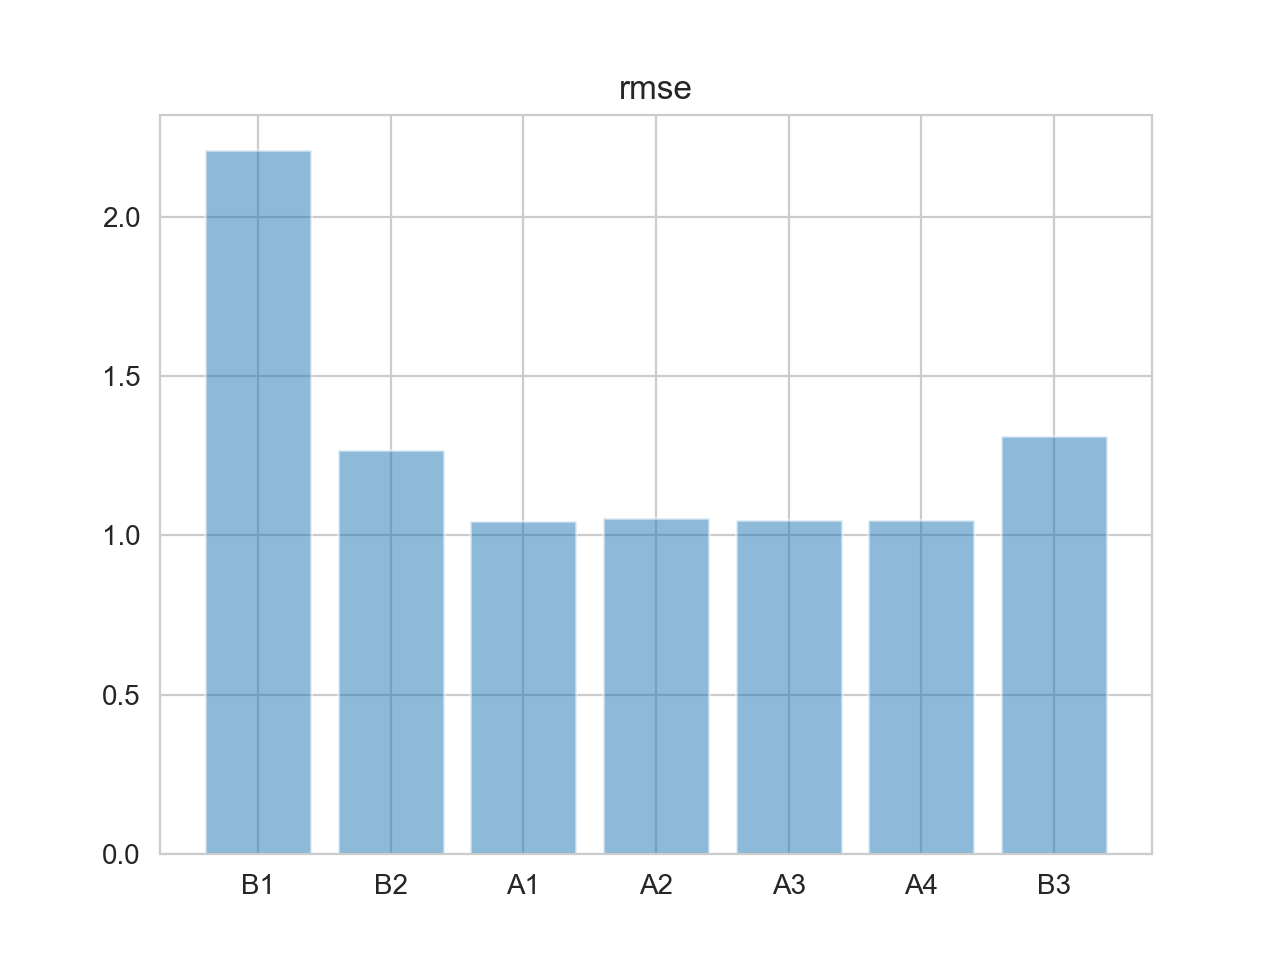

In [117]:
plt.bar(metric_results['model'], metric_results['rmse'], align='center', alpha=0.5, label = 'rmse')
plt.title('rmse')
plt.show()

<IPython.core.display.Javascript object>


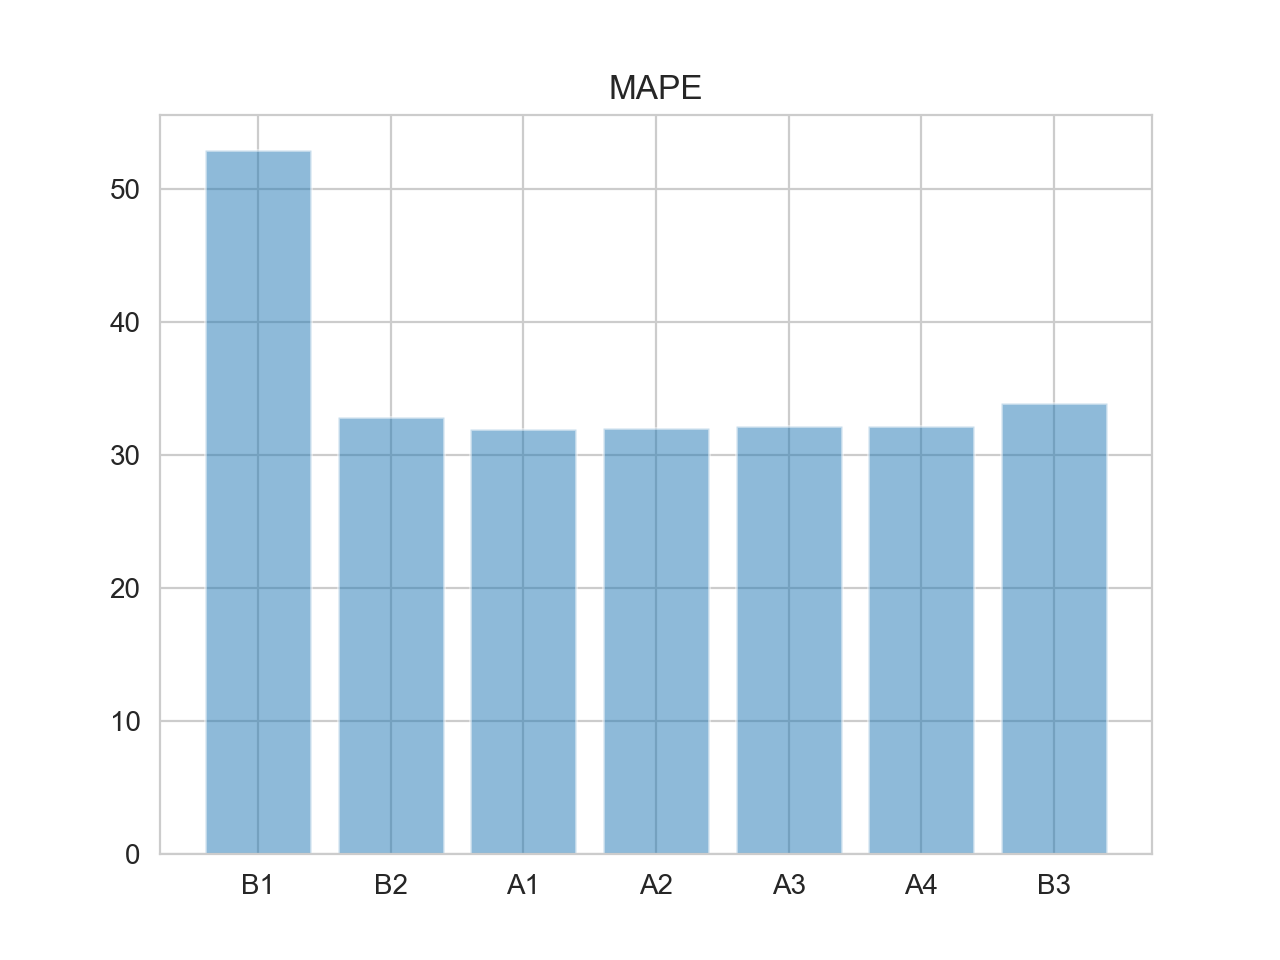

In [118]:
plt.bar(metric_results['model'], metric_results['mape'], align='center', alpha=0.5, label = 'MAPE')
plt.title('MAPE')
plt.show()

### Generate a plot for the ROC curves of each model into the same figure and include a legend to indicate the model name of each curve.

In [136]:
from sklearn import metrics

In [134]:
pred_results = {'B1':pd.read_csv('B1_item_based_CF_test_pred_1.csv', header = None),
          'B2':pd.read_csv('B2_SVD_test_pred_converge.csv', header = None),
          'B3':pd.read_csv('B3_test_pred_Random_Forest_1.csv', header = None),
          'A1':pd.read_csv('A1_SVD_test_pred_with_converge.csv', header = None),
          'A2':pd.read_csv('A2_SVD_test_result_pred_with_step_50_converge.csv', header = None),
          'A3':pd.read_csv('A3_SVD_v1_test_result_pred_converge.csv', header = None),
          'A4':pd.read_csv('A4_SVD_v2_test_result_pred_converge.csv', header = None)}

<IPython.core.display.Javascript object>


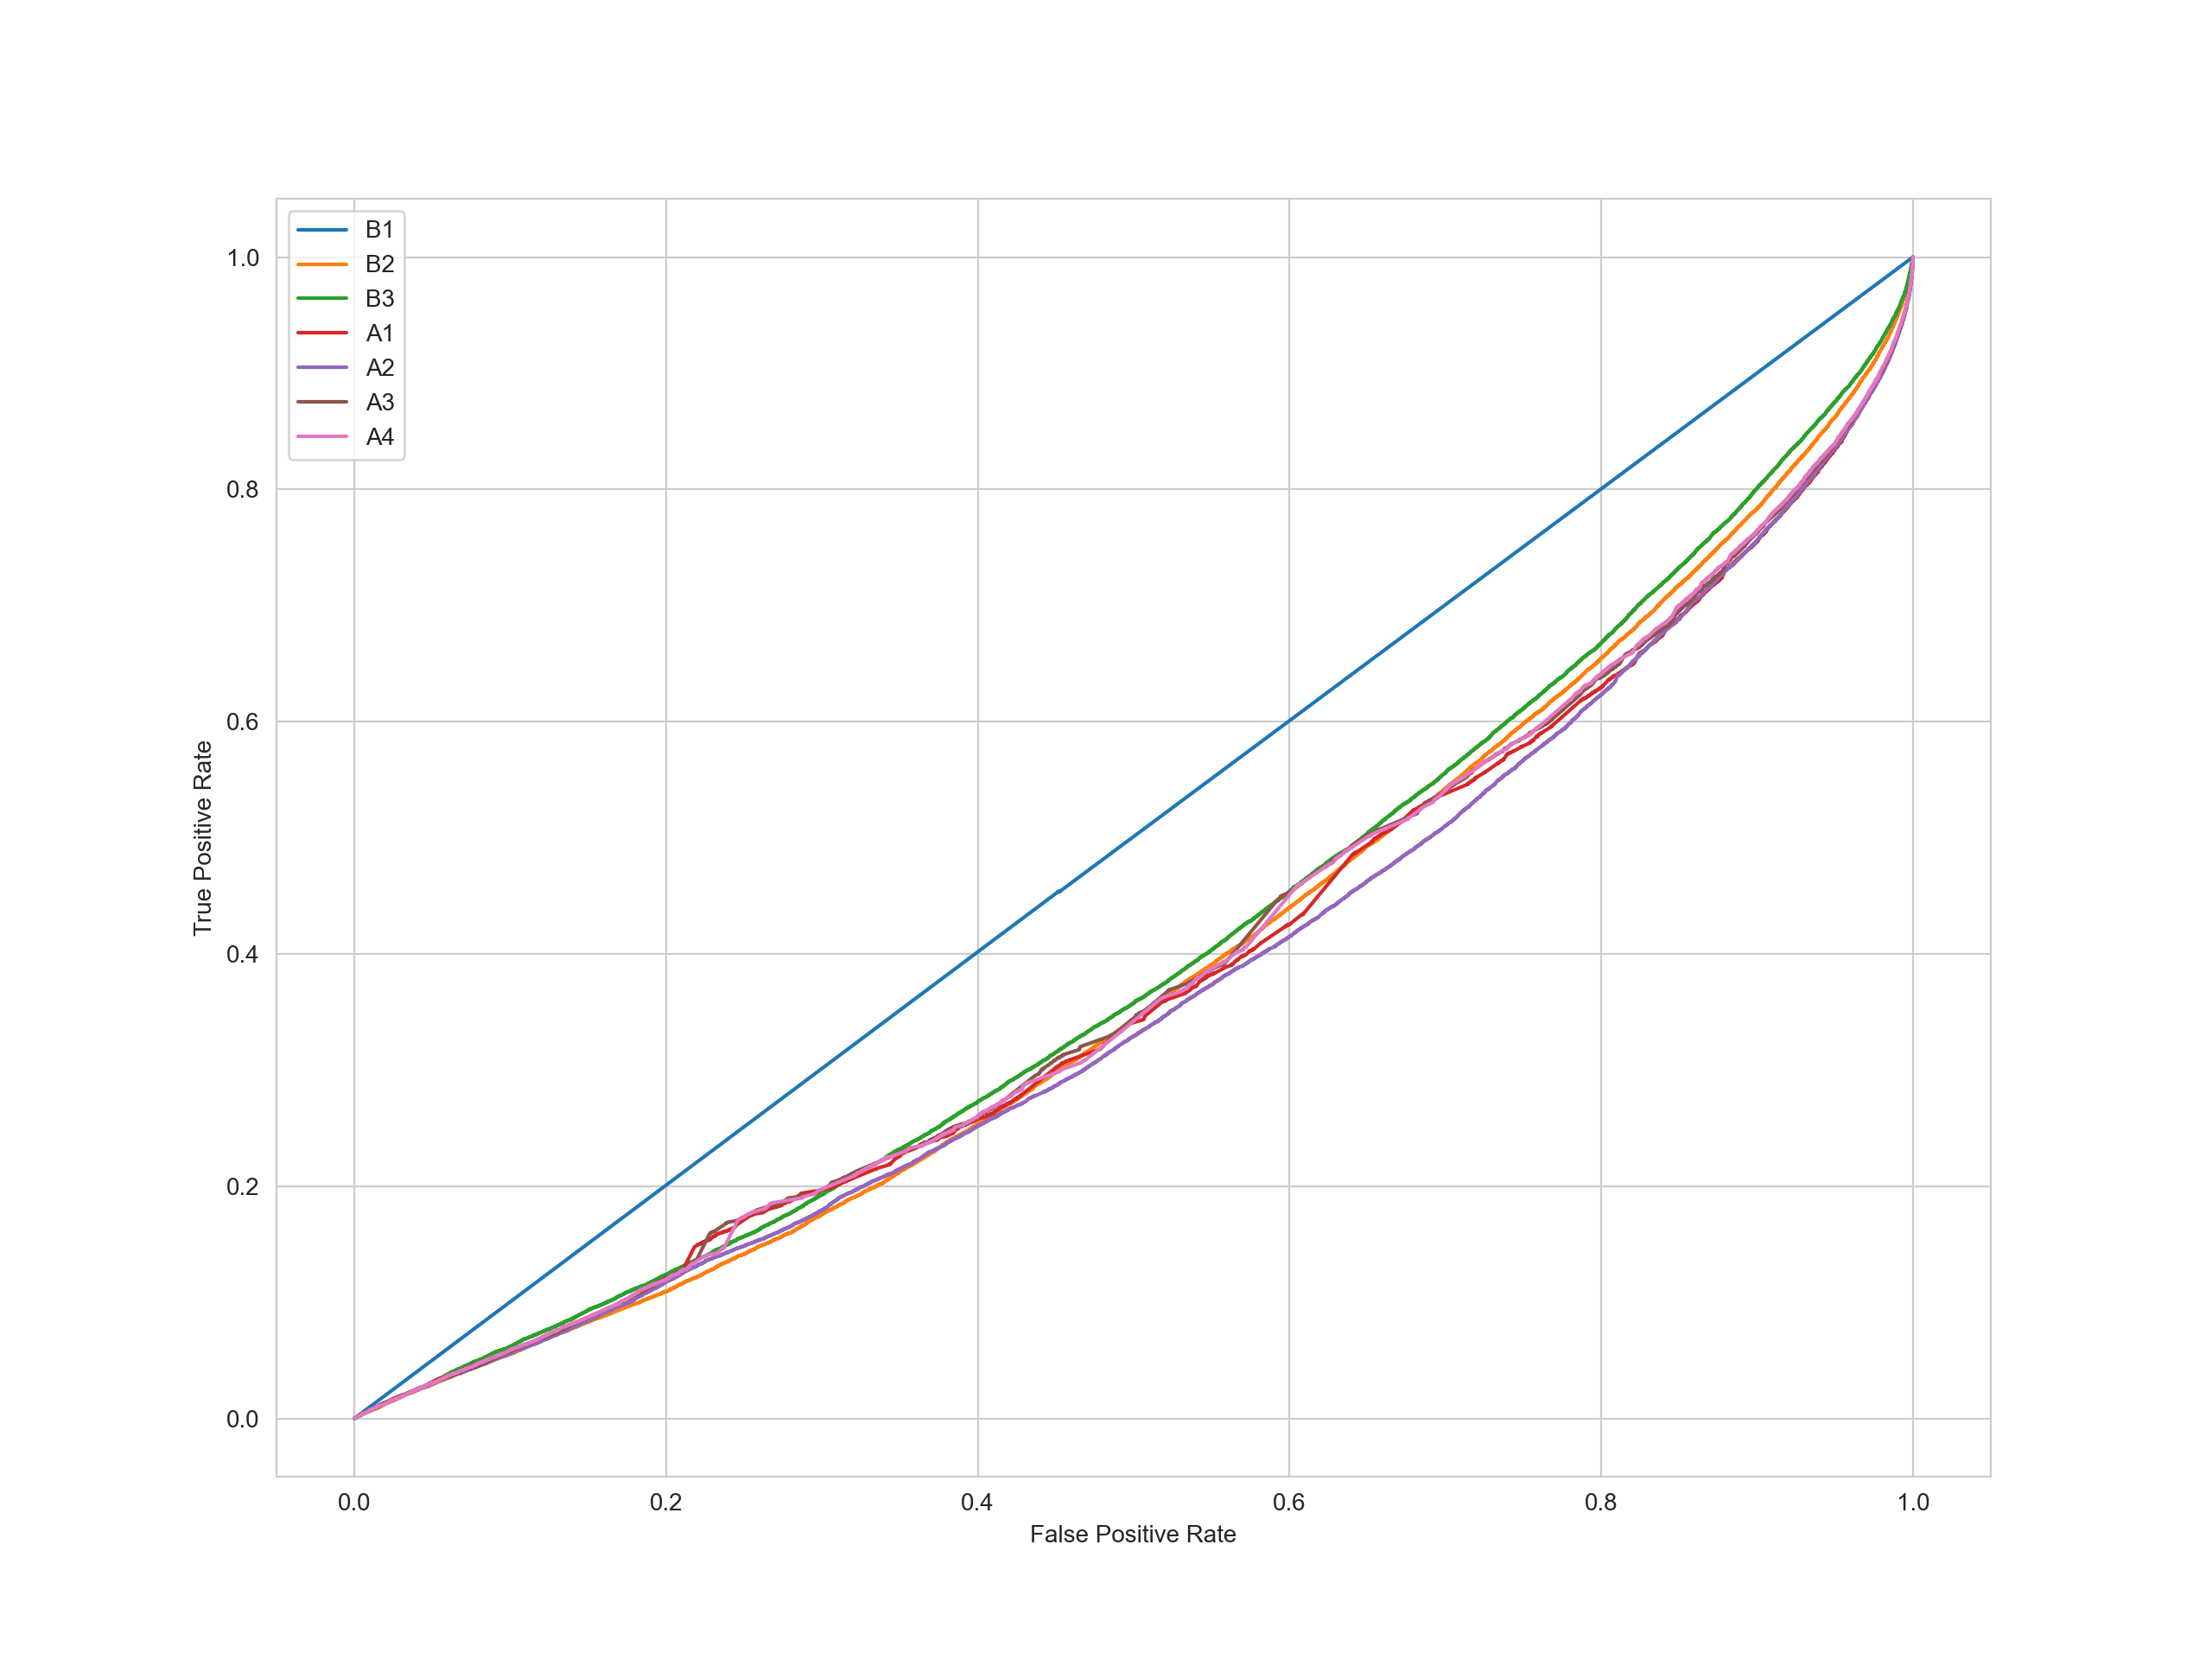

In [142]:
plt.figure(0).clf()
for model in results:
    y_pred_proba = [float(eval(results[model][1][i])[0]) for i in range(len(results[model]))]
    y_test = [float(eval(results[model][1][i])[1]) for i in range(len(results[model]))]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba, pos_label = 1)
    #create ROC curve
    plt.plot(fpr,tpr, label = model)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
plt.legend(loc=0)
plt.show()

For the metrics of mape and rmse, we could find out that model A1(SVD with bias) performs best.
Besides A1, all other improved model could performs well.
However, the item_based similarity model performs worst with highest rmse and mape values.

For the ROC curve above, we could find out that all models don't perform well...
By comparing these models, item_based similarity model performs the same as random model.
Except item_based similarity model, the SVD with implicit feedback model performs best.


Based on all the results, adding bias, feedbacks and terminal dynamic could actually increase the SVD model's performance. However, comparing all improvement models, the difference is a little. I think the reason might be we have lots of missing ratings, so that the predict rating might be around the average value for each model. 
Besides, if we look at the rmse and mape value for A3 model and A4 model, which are two models with time dynamic, we will find out that the values will be much smaller than other models. This is might because when we add time dynamic, it's more possible for models to be overfitting. Therefore, when we do the test on training data, the rmse and mape will be very small, but when we test on a new dataset, which includes data the model hasn't met before, the predicting rating will also be around the average rating, so the results of these two model are similar to other improvement models.

Due to time problems, I only choose one value for each parameter. I feel like I could do a grid-search, find the best parameters to increase the performance of each model. 

In [143]:
model_comparing_train.rmse

{'B1': 2.818094564108298,
 'B2': 0.7441923292015268,
 'A1': 0.7537673040981868,
 'A2': 0.8309953612297795,
 'A3': 0.5039626246944764,
 'A4': 0.499697992275144,
 'B3': 0.8255576211444372}

In [144]:
model_comparing_train.mape

{'B1': 67.69809565232424,
 'B2': 20.926667065770506,
 'A1': 22.70662566923289,
 'A2': 25.19881777617266,
 'A3': 10.632093431982897,
 'A4': 10.526043885986237,
 'B3': 22.682217104927382}